In [18]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
from matplotlib import pyplot as plt
from gpt import GPT

from matplotlib import pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Autotranslation of Tao FODO Lattice to GPT
---
This example uses pytao to load a Tao FODO lattice example and then converts it to a GPT lattice.  Note this will require installing the pytao package:

see: [https://github.com/bmad-sim/pytao](https://github.com/bmad-sim/pytao)

In [50]:
from pytao import Tao

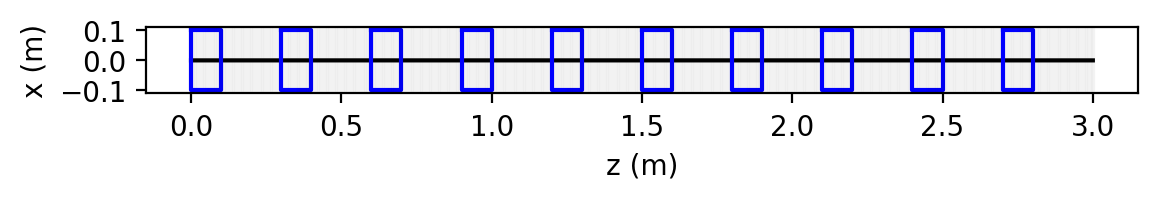

In [77]:
#tao = Tao('-init templates/tao/fodo/fodo.lat.bmad -noplot -external_plotting')
tao = Tao('-init templates/tao/fodo/tao.init -noplot -external_plotting')
G = GPT.from_tao(tao)
G.lattice.plot_floor(screen_alpha=0.025);

In [102]:
from pmd_beamphysics import single_particle, ParticleGroup

from scipy.constants import physical_constants, c

MC2 = physical_constants['electron mass energy equivalent in MeV'][0]*1e6

In [79]:
E = 150e6
p = np.sqrt(E**2 - MC2**2)

In [80]:
Px, Py = single_particle(x=1e-3, pz=p), single_particle(y=1e-3, pz=p)
PXFILE, PYFILE = 'x_probe_particle.h5', 'y_probe_particle.h5'

Px.write(PXFILE)
Py.write(PYFILE)

In [81]:
G.initial_particles = Px + Py

In [82]:
G.set_variables({'tmax': 5e-8})

{'tmax': True}

In [83]:
G.run()

In [84]:
print(G)


GPT object:
   Original input file: gpt.in
   Template location: /var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmpb33g2nsf
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmplaam_jhh
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 0.13097190856933594 (sec)


In [88]:
tao.cmd('set beam_init position_file = x_probe_particle.h5');
tao.cmd(f'set beam_init n_particle = {len(Px)}');
tao.cmd('set global track_type = beam');

ix = tao.lat_list('marker::*', 'ele.ix_ele')
PGxs = [ ParticleGroup(data=tao.bunch_data(i)) for i in ix]

tao.cmd('set beam_init position_file = y_probe_particle.h5');
tao.cmd(f'set beam_init n_particle = {len(Px)}');
tao.cmd('set global track_type = beam');

ix = tao.lat_list('marker::*', 'ele.ix_ele')
PGys = [ ParticleGroup(data=tao.bunch_data(i)) for i in ix]

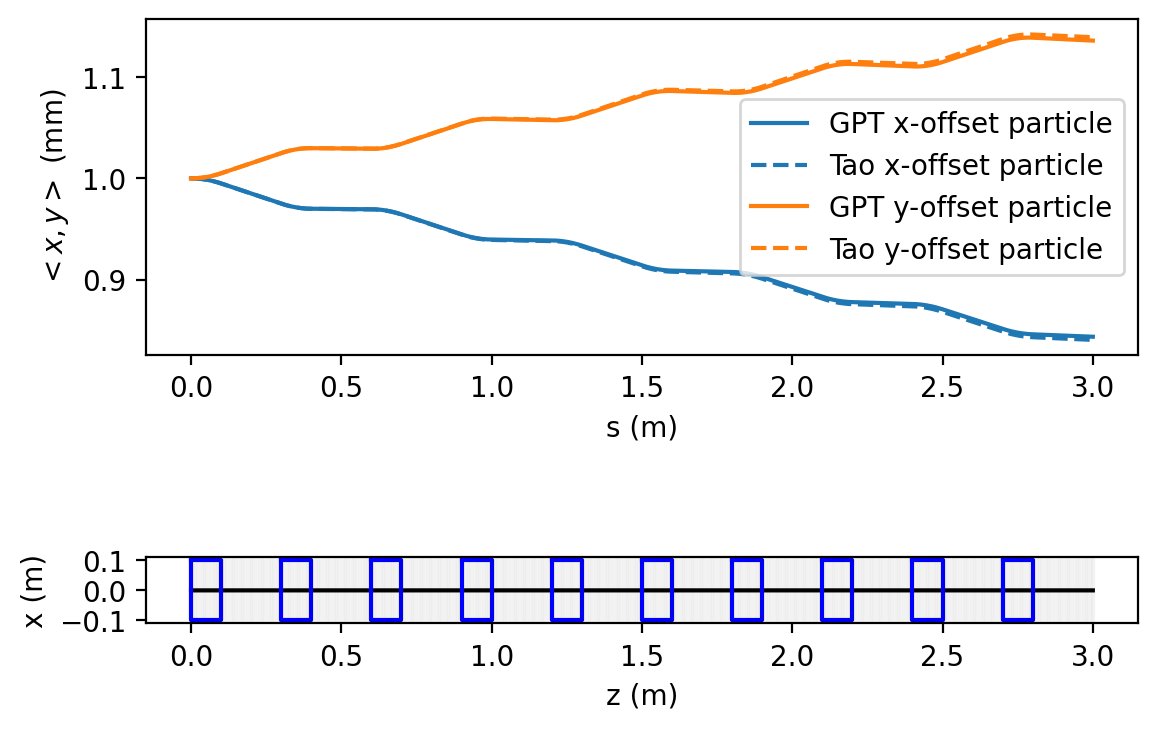

In [111]:
def get_mean_value(key, PGs):
    values = np.array([PG[f'mean_{key}'] for PG in PGs])
    return values

def get_sigma_value(key, PGs):
    values = np.array([PG[f'sigma_{key}'] for PG in PGs])
    return values

fig, axs = plt.subplots(2, 1)# constrained_layout=True)
tx = G.trajectory(1, data_type='screen')
ty = G.trajectory(2, data_type='screen')

axs[0].plot(c*tx['t'], tx['x']*1e3, color='tab:blue')
axs[0].plot(c*get_mean_value('t', PGxs), 1e3*get_mean_value('x', PGxs), '--', color='tab:blue')

axs[0].plot(c*ty['t'], ty['y']*1e3, color='tab:orange')
axs[0].plot(c*get_mean_value('t', PGys), 1e3*get_mean_value('y', PGys), '--', color='tab:orange')

axs[0].set_xlabel('s (m)')
axs[0].set_ylabel('$<x, y>$ (mm)')

G.lattice.plot_floor(screen_alpha=0.025, ax=axs[-1]);

axs[0].legend(['GPT x-offset particle', 'Tao x-offset particle', 'GPT y-offset particle', 'Tao y-offset particle']);